# Кластеризация
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][MS][HW02] <ФИО>`, где вместо `<ФИО>` указаны фамилия и имя__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы, а так же применить один из алгоритмов к задаче уменьшения цветности изображения.

In [1]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
from scipy.spatial import distance_matrix
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import cv2
from collections import deque
from typing import NoReturn

In [2]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

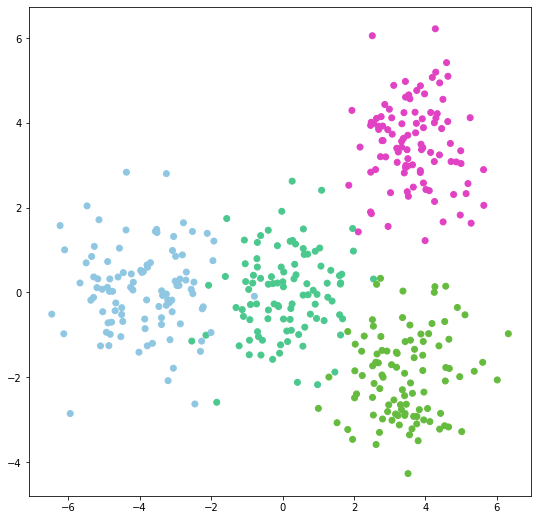

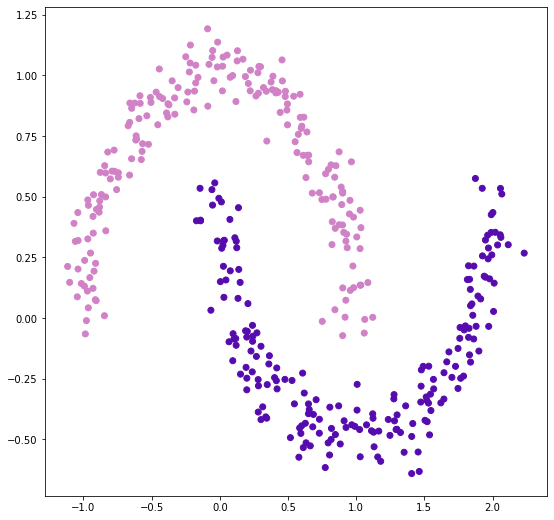

In [3]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 1 (3 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++

__Не забудте реинициализировать пустые кластеры!__

In [66]:
def distance(p1, p2):
    return np.sum((p1 - p2)**2)

def random(X: np.array, n_clusters: int, seed=2):
    rng = np.random.RandomState(seed)
    maxis = np.max(X, axis=0)
    minis = np.min(X, axis=0)
    samples=np.zeros((n_clusters, X.shape[1]))
    for s in  range(n_clusters):
        samples[s]=rng.uniform(minis, maxis)
    return samples

def sample(X: np.array, n_clusters: int, seed=2):
    rng = np.random.RandomState(seed)
    samples= rng.permutation(X.shape[0])[:n_clusters]
    return X[samples]


def k_means_plus(X: np.array, n_clusters: int, seed=2):
    rng = np.random.RandomState(seed)
    samples = X[rng.choice(X.shape[0])]
    for num in range(n_clusters-1):
        dist = []
        for i in range(X.shape[0]):
            point = X[i, :]
            d = np.inf
            for j in range(len(samples)):
                temp_dist = distance(point, samples[j])
                d = min(d, temp_dist)
            dist.append(d)
        dist = np.array(dist)
        next_centroid = X[np.argmax(dist), :]
        samples= np.vstack((samples, next_centroid))
        dist = []
    return (samples.reshape(n_clusters,-1))


class KMeans:
    def __init__(self, n_clusters: int, init: str = "random", 
                 max_iter: int = 300):
      
        self.n_clusters = n_clusters
        if init == "random":
            self.init = random
        elif init == "sample":
            self.init = sample
        elif init == "k-means++":
            self.init = k_means_plus
        self.max_iter=max_iter
        
    def fit(self, X: np.array, y = None) -> NoReturn:
        self.classes = {}
        self.labels=np.zeros(X.shape[0])
        self.eps=0.0001
        self.centroids=self.init(X, self.n_clusters)

        for i in range(self.max_iter):
            for j in range(self.n_clusters):
                self.classes[j] = []

            for iter in range(X.shape[0]):
                distances = [distance(X[iter], self.centroids[i]) for i in range(self.centroids.shape[0])]
                cluster = distances.index(min(distances))
                self.classes[cluster].append(X[iter])
                self.labels[iter]=int(cluster)
            self.previous = np.copy(self.centroids)

            for cluster in self.classes:
                self.centroids[cluster] = np.average(self.classes[cluster], axis = 0)
            close_flag=True
            for i in range(self.centroids.shape[0]):
                if np.sum(self.centroids[i] - self.previous[i]) > self.eps:
		                close_flag = False

            if close_flag:
		            break
            
    
    def predict(self, X: np.array) -> np.array:
        self.fit(X)
        return self.labels.astype(int)

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

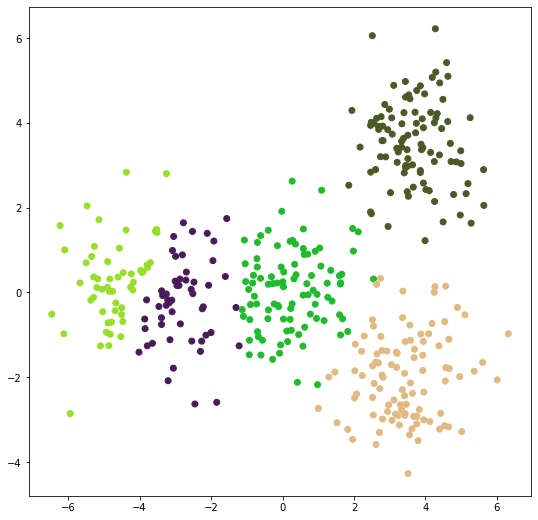

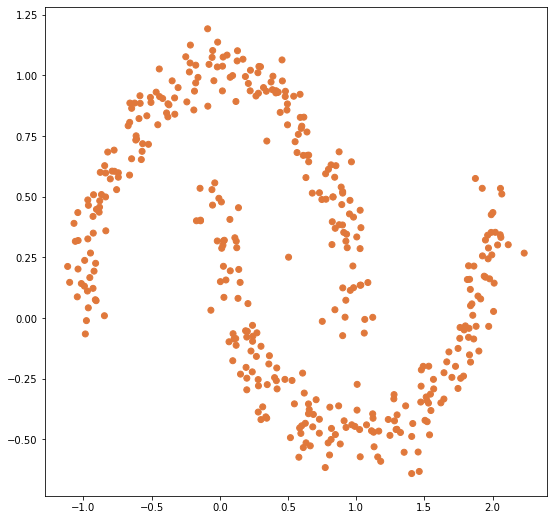

In [71]:
kmeans = KMeans(n_clusters=5, init='k-means++')
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=1, init='k-means++')
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 2 (2 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [ ]:
from queue import Queue

class DBScan:
    def __init__(self, eps: float = 0.5, min_samples: int = 5, 
                 leaf_size: int = 40, metric: str = "euclidean"):
      
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size= leaf_size
        self.metric = metric

        self.cluster_label = -1
        self.noise = -1
    def fit_predict(self, X: np.array, y = None) -> np.array:
        
        X = np.append(X, np.array([[-1]*X.shape[0]]).reshape(-1,1), axis=1)
        for x in range(X.shape[0]):
            
            if X[x,2] != -1:
                continue

            p = X[x,:2]

            neighbors = self.rangeQuery(p.reshape(1, -1),X[:,:2])
            
            if len(neighbors) < self.min_samples:
                X[x,2] = self.noise
                continue  

            self.cluster_label += 1
            X[x,2] = self.cluster_label
            found_neighbors = neighbors
            q = Queue()
            
            for x in neighbors:
                q.put(x)
            
            while q.empty() == False:
                current = q.get()
                if X[current,2] == 0:
                    X[current,2] = self.cluster_label
                if X[current,2] != -1:
                    continue

                X[current,2] = self.cluster_label
                
                point = X[current,:2]
                neighbors2 = self.rangeQuery(point.reshape(1, -1), X[:,:2])
                if len(neighbors2) >= self.min_samples:
                    for x in neighbors2:
                        if x not in found_neighbors:
                            q.put(x)
                            found_neighbors=np.append(found_neighbors,x)  
        return  X[:,2].astype(int)      
    
    def rangeQuery(self, x, X):
        
        tree = KDTree(X, self.leaf_size, metric=self.metric)
        ind= (tree.query_radius(x, r=self.eps))[0]
        return ind


Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

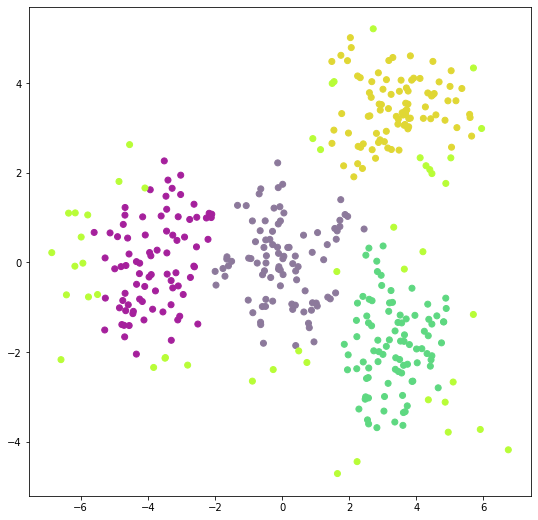

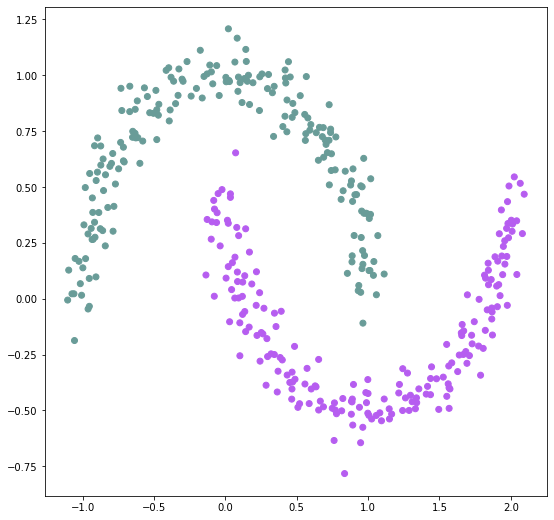

In [ ]:
dbscan = DBScan(eps = 0.6, min_samples = 7)

labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(eps = 0.2, min_samples = 5)
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 3 (3 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [ ]:
import math


def average(X: np.array, Y: np.array):
    return np.mean((X, Y), axis=0)

def single(X: np.array, Y: np.array):
    return np.minimum(X, Y)

def complete(X: np.array, Y: np.array):
    return np.maximum(X, Y)

class AgglomertiveClustering:
    def __init__(self, n_clusters: int = 16, linkage: str = "average"):

        self.n_clusters=n_clusters
        if linkage == "average":
            self.linkage = average
        elif linkage == "single":
            self.linkage = single
        elif linkage == "complete":
            self.linkage = complete
        self.c_num=0
        self.cluster_list=[]

    def fit_predict(self, X: np.array, y = None) -> np.array:

        self.c_num = X.shape[0]
        ans= np.full(self.c_num, -1)
        clusters = np.array([a for a in range(self.c_num)])
        cur = clusters

        dist = distance_matrix(X, X)
        np.fill_diagonal(dist, np.Inf)
      

        while self.n_clusters < cur.size :

            mini=np.argmin(dist)
            f_point = mini // self.c_num
            s_point = mini % self.c_num

            dist[f_point, :] = self.linkage(dist[f_point], dist[s_point])
            dist[:, f_point] = dist[f_point, :]

            dist[s_point, :] = np.Inf
            dist[:, s_point] = np.Inf
            dist[f_point, f_point] = np.Inf

            clusters[np.where(clusters == s_point)] = f_point
            cur = np.unique(clusters)

        num=0
        for i in cur:
            ans[np.where(clusters == i)] = num
            num += 1

        return ans




Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

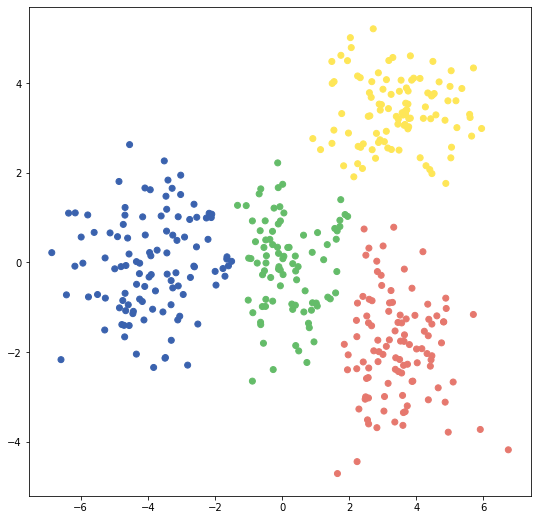

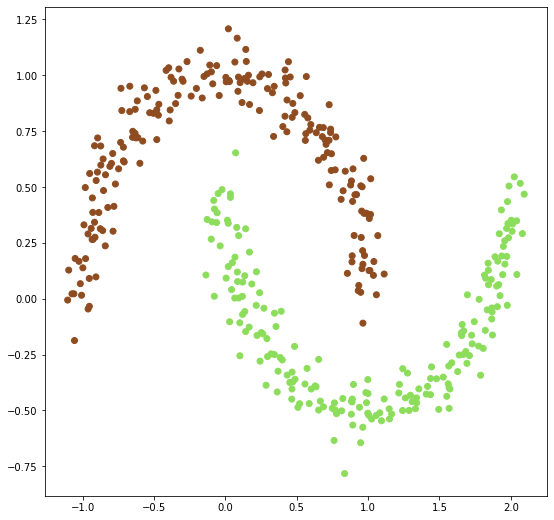

In [ ]:
agg_clustering = AgglomertiveClustering(n_clusters=4, linkage='complete')
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2, linkage='single')
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 4 (1 балл)
Реализуйте методы считывания и записи изображения при помощи библиотеки OpenCV. 

#### Описание методов
`read_image(path)` читает изображение и возвращает его в виде трехмерного numpy массива размера `(N, M, C)`, где `N` и `M` - размеры изображения, а `C` - количество цветов (3 для обычного изображения)
`save_image(image, path)` сохраняет изображение.

__Учтите, что `cv2.imread` считывает изображение в цветовой схеме BGR. После считывания необходимо перевести его в RGB и нормализовать__

In [80]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [103]:
def read_image(path: str) -> np.array:
    img = cv2.imread(path)
    img = (cv2.cvtColor(img, cv2.COLOR_BGR2RGB)).astype(float) / 255
    return img
    

def show_image(image: np.array) -> NoReturn:
    plt.figure(figsize=np.array(image.shape[:-1]) / 50)
    plt.imshow(image)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def save_image(image: np.array, path: str) -> NoReturn:
    image = np.float32(image * 255)
    new_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(path, new_image)


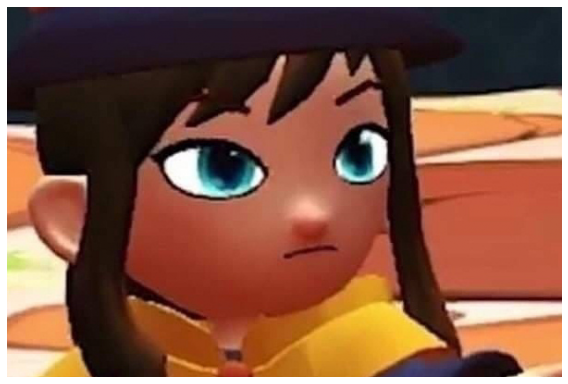

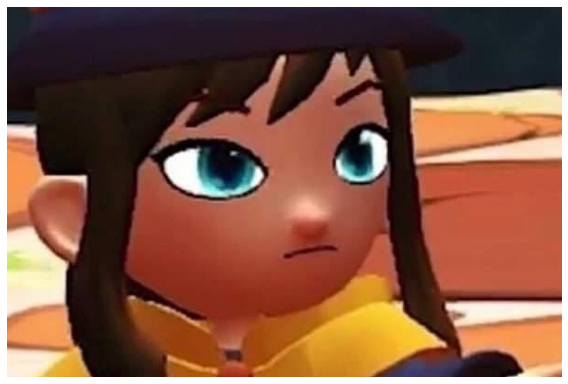

In [104]:
show_image(read_image("/content/gdrive/My Drive/img.jpg"))
save_image(read_image("/content/gdrive/My Drive/img.jpg"), "/content/gdrive/My Drive/img_new.jpg")
show_image(read_image("/content/gdrive/My Drive/img_new.jpg") )

### Задание 5 (1 балл)
Реализуйте функцию, которая будет кластеризовать цвета изображения одним из реализованных алгоритмов. Интерфейс этой функции можно менять. Функция должна возвращать новое изображение, в котором цвета заменены на цвета кластеров.

Затем примените ее к цветам изображения.

__Примечание: это задание проще всего выполнить при помощи KMeans__

In [ ]:
def clusterize_image(image, num):
    img2d=image.reshape(-1, 3)
    kmeans = KMeans(n_clusters=num, init='k-means++')
    print('built')
    clusters = kmeans.predict(img2d)
    print('predicted')

    new_img = np.zeros_like(img2d)
    cluster_colors = [np.mean(img2d[clusters == i], axis=0) for i in range(num)]
    for i in range(num):
        new_img[clusters == i] = cluster_colors[i]
    new_img = new_img.reshape(image.shape)
    clusters_statistics(img2d, np.array(cluster_colors), clusters)  # Very slow (:
    return new_img

built






predicted


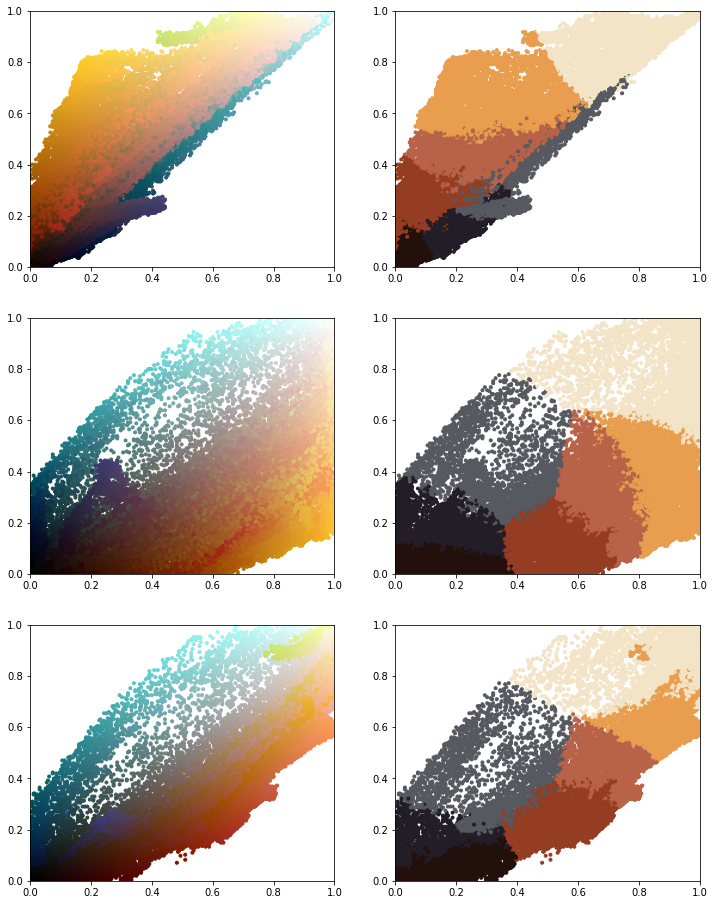

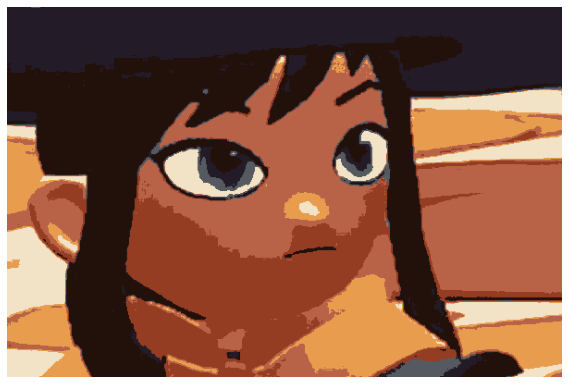

In [ ]:
image = read_image("/content/gdrive/My Drive/img.jpg")
result = clusterize_image(image,7)
show_image(result)
save_image(result, "/content/gdrive/My Drive/img.jpg")